<a href="https://colab.research.google.com/github/leadbreak/spark/blob/main/study/Spark_Study_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 00. PreWorks


In [29]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed spark-nlp==2.5.1

openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)
  Using cached pyspark-2.4.4-py2.py3-none-any.whl
  Using cached py4j-0.10.7-py2.py3-none-any.whl (197 kB)


  Using cached spark_nlp-2.5.1-py2.py3-none-any.whl (121 kB)


In [30]:
! mkdir -p data

In [31]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/mini_newsgroups.tar.gz

--2021-09-09 05:47:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/mini_newsgroups.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1860687 (1.8M) [application/x-httpd-php]
Saving to: ‘mini_newsgroups.tar.gz.1’

mini_newsgroups.tar 100%[===================>]   1.77M  3.71MB/s    in 0.5s    

2021-09-09 05:47:35 (3.71 MB/s) - ‘mini_newsgroups.tar.gz.1’ saved [1860687/1860687]



In [32]:
! tar xzf mini_newsgroups.tar.gz -C ./data/

# STEP 01. Spark NLP beginners


## Ch.01 Processing Words

In [5]:
import os

from pyspark.sql.types import *
from pyspark.ml import Pipeline

import sparknlp
from sparknlp import DocumentAssembler, Finisher

spark = sparknlp.start()

In [6]:
space_path = os.path.join('data', 'mini_newsgroups', 'sci.space')
texts = spark.sparkContext.wholeTextFiles(space_path)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

texts = spark.createDataFrame(texts, schema=schema).persist()

In [9]:
## excerpt from mini newsgroups modified for examples
example = '''
Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.
'''

example = spark.createDataFrame([('.', example)], schema=schema).persist()
example.show()

+----+--------------------+
|path|                text|
+----+--------------------+
|   .|
Nick's right abo...|
+----+--------------------+



## Ch.02 Tokenization

In Spark NLP, the tokenizer is more sophisticated than just single regex. It takes the following parameters (apart from the usual input and output column name parameters):

compositeTokens
These are multitoken words that you may not want to split (e.g., "New York").
targetPattern
This is the basic pattern for defining candidate tokens.
infixPatterns
These are the patterns for separating tokens that are found inside candidate tokens.
prefixPattern
This is the pattern for separating tokens that are found at the beginning of candidate tokens.
suffixPattern
This is the pattern for separating tokens that are found at the end of candidate tokens.
The algorithm works in the following steps:

Protect the composite tokens.
Create the candidate tokens.
Separate out the prefix, infix, and suffix patterns.

In [10]:
from pyspark.ml.feature import RegexTokenizer

# 공백을 기준으로 분리
ws_tokenizer = RegexTokenizer()\
    .setInputCol('text')\
    .setOutputCol('ws_tokens')\
    .setPattern('\\s+')\
    .setGaps(True)\
    .setToLowercase(False)

text, tokens = ws_tokenizer.transform(example)\
    .select("text", "ws_tokens").first()

print(f"text : \n{text}\n")
print(f"tokens : \n{tokens}")

text : 

Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.


tokens : 
["Nick's", 'right', 'about', 'this.', "It's", 'always', 'easier', 'to', 'obtian', 'forgiveness', 'than', 'permission.', 'Not', 'many', 'poeple', 'remember', 'that', "Britan's", 'Kng', 'George', 'III', 'expressly', 'forbade', 'his', 'american', 'subjects', 'to', 'cross', 'the', 'alleghany/appalachian', 'mountains.', 'Said', 'subjects', 'basically', 'said,', '"Stop', 'us', 'if', 'you', 'can."', 'He', "couldn't."]


In [11]:
# 공백과 특수문자를 기준으로 분리
b_tokenizer = RegexTokenizer()\
    .setInputCol('text')\
    .setOutputCol('b_tokens')\
    .setPattern('\\s+|\\b')\
    .setGaps(True)\
    .setToLowercase(False)

text, tokens = b_tokenizer.transform(example)\
    .select("text", "b_tokens").first()

print(f"text : \n{text}\n")
print(f"tokens : \n{tokens}")

text : 

Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.


tokens : 
['Nick', "'", 's', 'right', 'about', 'this', '.', 'It', "'", 's', 'always', 'easier', 'to', 'obtian', 'forgiveness', 'than', 'permission', '.', 'Not', 'many', 'poeple', 'remember', 'that', 'Britan', "'", 's', 'Kng', 'George', 'III', 'expressly', 'forbade', 'his', 'american', 'subjects', 'to', 'cross', 'the', 'alleghany', '/', 'appalachian', 'mountains', '.', 'Said', 'subjects', 'basically', 'said', ',', '"', 'Stop', 'us', 'if', 'you', 'can', '."', 'He', 'couldn', "'", 't', '.']


In [12]:
from sparknlp.annotator import Tokenizer

# 좀 더 정교하게 특수문자 이후에 바로 문자가 오는 것도 하나의 토큰으로 간주
assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')

tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')

finisher = Finisher()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCols(['tokens'])\
    .setOutputAsArray(True)
    
pipeline = Pipeline()\
    .setStages([assembler, tokenizer, finisher])

text, tokens = pipeline.fit(texts).transform(example)\
    .select("text", "tokens").first()

print(f"text : \n{text}\n")
print(f"tokens : \n{tokens}")

text : 

Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.


tokens : 
["Nick's", 'right', 'about', 'this', '.', "It's", 'always', 'easier', 'to', 'obtian', 'forgiveness', 'than', 'permission', '.', 'Not', 'many', 'poeple', 'remember', 'that', "Britan's", 'Kng', 'George', 'III', 'expressly', 'forbade', 'his', 'american', 'subjects', 'to', 'cross', 'the', 'alleghany/appalachian', 'mountains', '.', 'Said', 'subjects', 'basically', 'said', ',', '"', 'Stop', 'us', 'if', 'you', 'can', '."', 'He', "couldn't", '.']


## Ch.03 Vocabulary Reduction
Most NLP tasks involve turning the text into vectors. Initially, your vectors will have dimension equal to your vocabulary. An implicit assumption to doing this is that the words are orthogonal to each other. In terms of words, this means that "cat," "dog," and "dogs" are all considered equally different. We would like to represent words in a vector space that is somehow related to their meaning, but that is more complicated. We will cover such representations in Chapters #topic_modeling and #word_embeddings. There are simpler ways to tackle this problem, however. If we know that two words are almost the same, or are at least equivalent for our purposes, we can represent them with the same dimension in our vector. This will help classification, regression, and search tasks. So how can we do this? We can use our knowledge of morphology (how words are constructed from smaller words and affixes). We can remove affixes before constructing our vector. The two primary techniques for doing this are stemming and lemmatization.

### Stemming
- Stemming is the process of removing affixes and leaving a word stem. This is done according to sets of rules that determine what characters to delete or replace. The first stemming algorithm was created by Julie Beth Lovins in 1968, although there had been earlier work done on the subject. In 1980, Martin Porter created the Porter Stemmer. This is certainly the most well-known stemming algorithm. He later created a domain-specific language and associated tools for writing stemming algorithms called snowball. Although people almost always use a predefined stemmer, if you find that there are affixes that are not being removed but should be, or the other way around, consider writing or modifying an existing algorithm.

### Lemmatization
- Lemmatization is the process of replacing a word with its lemma or head-word. The lemma is the form of a word that has a full dictionary entry. For example, if you look up "oxen" in a dictionary, it will likely redirect you to "ox." Algorithmically, this is easy to implement but is dependent on the data you use for looking up lemmas.

### Stemming Versus Lemmatization
- There are pros and cons to both stemming and lemmatization.

 -  Stemming has the pro of requiring almost no memory, unlike lemmatization, which requires a dictionary.
 - Lemmatization is generally quicker, since it is just a hash map lookup.
 - Stemming can be easily tuned because it is based on an algorithm instead of a data source.
 - Lemmatization returns an actual word, which makes inspecting results easier. Which method you use will depend on your task and your resource constraints.

- Use stemming if:
 - You need to tune how much you reduce your vocabulary.
 - You have tight memory constraints and fewer time constraints.
 - You expect many new or unknown words.
- Use lemmatization if:
 - You need results of processing exposed to users.
 - You have tight time constraints and less restriction on memory.

In [15]:
from sparknlp.annotator import Stemmer, Lemmatizer, LemmatizerModel

assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')
tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')
stemmer = Stemmer()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('stems_annotations')
# The next line downloads lemmatizer "model". Here, "training" 
# is reading the user supplied dictionary
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('lemma_annotations')
finisher = Finisher()\
    .setInputCols(['stems_annotations', 'lemma_annotations'])\
    .setOutputCols(['stems', 'lemmas'])\
    .setOutputAsArray(True)

pipeline = Pipeline()\
    .setStages([
        assembler, tokenizer, stemmer, lemmatizer, finisher])
text, stems, lemmas = pipeline.fit(texts).transform(example)\
    .select("text", "stems", "lemmas").first()

print(f"text : \n{text}\n")
print(f"stems : \n{stems}\n")
print(f"lemmas : \n{lemmas}")

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
text : 

Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.


stems : 
["nick'", 'right', 'about', 'thi', '.', "it'", 'alwai', 'easier', 'to', 'obtian', 'forgiv', 'than', 'permiss', '.', 'not', 'mani', 'poepl', 'rememb', 'that', "britan'", 'kng', 'georg', 'iii', 'expressli', 'forbad', 'hi', 'american', 'subject', 'to', 'cross', 'the', 'alleghany/appalachian', 'mountain', '.', 'said', 'subject', 'basic', 'said', ',', '"', 'stop', 'u', 'if', 'you', 'can', '."', 'he', "couldn't", '.']

lemmas : 
["Nick's", 'right', 'about', 'this', '.', "It's", 'always', 'easy', 'to', 'obtian', 'forgiveness', 'than', 'permission', '.', 'Not', 'many', 'poeple', 'remember',

## Ch.04 Spelling Correction

In [17]:
from sparknlp.annotator import NorvigSweetingModel
from sparknlp.annotator import SymmetricDeleteModel

# Norvig pretrained
assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')
tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')
norvig_pretrained = NorvigSweetingModel.pretrained()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('norvig_annotations')
finisher = Finisher()\
    .setInputCols(['norvig_annotations'])\
    .setOutputCols(['norvig'])\
    .setOutputAsArray(True)

pipeline = Pipeline()\
    .setStages([
    assembler, tokenizer, norvig_pretrained, lemmatizer, finisher])
text, norvig = pipeline.fit(texts).transform(example)\
    .select("text", "norvig").first()

print(f"text : \n{text}\n")
print(f"norvig : \n{norvig}")

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]
text : 

Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.


norvig : 
['Nicks', 'right', 'about', 'this', '.', "it's", 'always', 'easier', 'to', 'obtain', 'forgiveness', 'than', 'permission', '.', 'Not', 'many', 'people', 'remember', 'that', "Britan's", 'Kng', 'George', 'III', 'expressly', 'forbade', 'his', 'americana', 'subjects', 'to', 'cross', 'the', 'alleghany/appalachian', 'mountains', '.', 'Said', 'subjects', 'basically', 'said', ',', '"', 'Stop', 'us', 'if', 'you', 'can', '."', 'He', "couldn't", '.']


## Ch.05 Normalization
This is a more heuristic-based cleanup step. If you are processing data scraped from the web, it is not uncommon to have HTML artifacts (tags, HTML encodings, etc.) left behind. Getting rid of these artifacts can reduce your vocabulary by quite a bit. If your task does not require numbers or anything nonalphabetic, for instance, you can also use normalization to remove these.

In [18]:
from sparknlp.annotator import Normalizer

assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')
tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')
norvig_pretrained = NorvigSweetingModel.pretrained()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('norvig_annotations')
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['norvig_annotations'])\
    .setOutputCol('lemma_annotations')
normalizer = Normalizer()\
    .setInputCols(['lemma_annotations'])\
    .setOutputCol('normtoken_annotations')\
    .setLowercase(True)
finisher = Finisher()\
    .setInputCols(['normtoken_annotations'])\
    .setOutputCols(['normtokens'])\
    .setOutputAsArray(True)

sparknlp_pipeline = Pipeline().setStages([
    assembler, tokenizer, norvig_pretrained, 
    lemmatizer, normalizer, finisher
])

pipeline = Pipeline()\
    .setStages([
        assembler, tokenizer, norvig_pretrained, 
        lemmatizer, normalizer, finisher])
text, normalized = pipeline.fit(texts).transform(example)\
    .select("text", "normtokens").first()

print(f"text : \n{text}\n")
print(f"normalized : \n{normalized}")

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
text : 

Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.


normalized : 
['nicks', 'right', 'about', 'this', 'itys', 'always', 'easy', 'to', 'obtain', 'forgiveness', 'than', 'permission', 'not', 'many', 'people', 'remember', 'that', 'britans', 'kng', 'george', 'iii', 'expressly', 'forbid', 'he', 'americana', 'subject', 'to', 'cross', 'the', 'alleghanyappalachian', 'mountain', 'said', 'subject', 'basically', 'say', 'stop', 'we', 'if', 'you', 'can', 'he', 'couldnt']


## Ch.06 Bag-of-Words(Vectorize)
Now that we have reduced our vocabulary by combining similar and misspelled words and removing HTML artifacts, we can feel confident that the vocabulary we are working with is a realistic reflection of the content of our documents. The next step is to turn these words into vectors for our model. There are many techniques for doing this, but we will start with the most straightforward approach, called bag-of-words. A bag (also called a multiset), is a set in which each element has a count. If you are familiar with the Python collection Counter, that is a good way to understand what a bag is. And so, a bag-of-words is the count of the words in our document. Once we have these counts, we turn them into a vector by mapping each unique word to an index.

In [19]:
text = "the cat in the hat"
tokens = text.split()
tokens

['the', 'cat', 'in', 'the', 'hat']

In [20]:
from collections import Counter

counts = Counter(tokens)
counts

Counter({'cat': 1, 'hat': 1, 'in': 1, 'the': 2})

In [21]:
index = {token: ix for ix, token in enumerate(counts.keys())}
index

{'cat': 1, 'hat': 3, 'in': 2, 'the': 0}

In [22]:
import numpy as np

vec = np.zeros(len(index))

for token, count in counts.items():
    vec[index[token]] = count
    
vec

array([2., 1., 1., 1.])

In [23]:
from pyspark.ml.feature import CountVectorizer

assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')
tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')
norvig_pretrained = NorvigSweetingModel.pretrained()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('norvig_annotations')
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['norvig_annotations'])\
    .setOutputCol('lemma_annotations')
normalizer = Normalizer()\
    .setInputCols(['lemma_annotations'])\
    .setOutputCol('normtoken_annotations')\
    .setLowercase(True)
finisher = Finisher()\
    .setInputCols(['normtoken_annotations'])\
    .setOutputCols(['normtokens'])\
    .setOutputAsArray(True)

sparknlp_pipeline = Pipeline().setStages([
    assembler, tokenizer, norvig_pretrained, 
    lemmatizer, normalizer, finisher
])

count_vectorizer = CountVectorizer()\
    .setInputCol('normtokens')\
    .setOutputCol('bows')

pipeline = Pipeline().setStages([sparknlp_pipeline, count_vectorizer])
model = pipeline.fit(texts)
processed = model.transform(example)
text, normtokens, bow = processed\
    .select("text", "normtokens", 'bows').first()

print(f"text : \n{text}\n")
print(f"normtokens : \n{normtokens}\n")
print(f"bow : \n{bow}")

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
text : 

Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.


normtokens : 
['nicks', 'right', 'about', 'this', 'its', 'always', 'easy', 'to', 'obtain', 'forgiveness', 'than', 'permission', 'not', 'many', 'people', 'remember', 'that', 'britans', 'kng', 'george', 'iii', 'expressly', 'forbid', 'he', 'americana', 'subject', 'to', 'cross', 'the', 'alleghanyappalachian', 'mountain', 'said', 'subject', 'basically', 'say', 'stop', 'we', 'if', 'you', 'can', 'he', 'couldnt']

bow : 
(5437,[0,3,8,14,16,24,28,30,32,46,52,67,78,126,150,185,216,338,375,442,757,804,

In [24]:
count_vectorizer_model = model.stages[-1]

vocab = count_vectorizer_model.vocabulary
print(vocab[:20])

['the', 'be', 'of', 'to', 'and', 'a', 'in', 'for', 'that', 'on', 'have', 'it', 'i', 'from', 'you', 'space', 'this', 'they', 'as', 'by']


## Ch.07 N-Gram

In [25]:
# examples of N-Gram
text = "the quick brown fox jumped over the lazy dog"
tokens = ["the", "quick", "brown", "fox", "jumped", "over", "the", "lazy", "dog"]
unigrams = [('the',), ('quick',), ('brown',), ('fox',), ('jumped',), ('over',), ('the',), ('lazy',), ('dog',)]
bigrams = [('the', 'quick'), ('quick', 'brown'), ('brown', 'fox'), ('fox', 'jumped'), ('jumped', 'over'), ('over', 'the'), ('the', 'lazy'), ('lazy', 'dog')]
trigrams = [('the', 'quick', 'brown'), ('quick', 'brown', 'fox'), ('brown', 'fox', 'jumped'), ('fox', 'jumped', 'over'), ('jumped', 'over', 'the'), ('over', 'the', 'lazy'), ('the', 'lazy', 'dog')]

In [26]:
from pyspark.ml.feature import NGram

bigrams = NGram()\
    .setN(2)\
    .setInputCol("normtokens")\
    .setOutputCol("bigrams")
trigrams = NGram()\
    .setN(3)\
    .setInputCol("normtokens")\
    .setOutputCol("trigrams")

pipeline = Pipeline().setStages([sparknlp_pipeline, bigrams, trigrams])
model = pipeline.fit(texts)
processed = model.transform(example)
text, normtokens, bigrams, trigrams = processed\
    .select("text", "normtokens", 'bigrams', 'trigrams').first()

print(f"text : \n{text}\n")
print(f"normtokens : \n{normtokens}\n")
print(f"bigrams : \n{bigrams}\n")
print(f"trigrams : \n{trigrams}")

text : 

Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.


normtokens : 
['nicks', 'right', 'about', 'this', 'dts', 'always', 'easy', 'to', 'obtain', 'forgiveness', 'than', 'permission', 'not', 'many', 'people', 'remember', 'that', 'britans', 'kng', 'george', 'iii', 'expressly', 'forbid', 'he', 'americana', 'subject', 'to', 'cross', 'the', 'alleghanyappalachian', 'mountain', 'said', 'subject', 'basically', 'say', 'stop', 'we', 'if', 'you', 'can', 'he', 'couldnt']

bigrams : 
['nicks right', 'right about', 'about this', 'this dts', 'dts always', 'always easy', 'easy to', 'to obtain', 'obtain forgiveness', 'forgiveness than', 'than permission', 'permission not', 'not many', 'many people', 'people remember', 'remember that', 'that britans', 'britans

## Ch.08 Visualizing : Word and Document Distributions

explain_document_ml download started this may take some time.
Approx size to download 9.4 MB
[OK!]


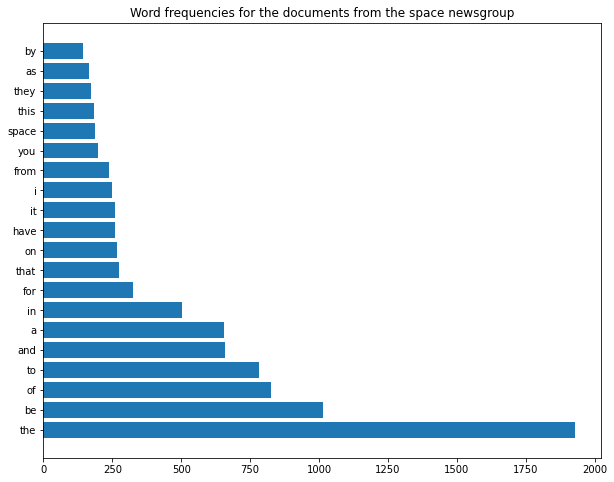

In [27]:
from sparknlp.pretrained import PretrainedPipeline

space_path = os.path.join('data', 'mini_newsgroups', 'sci.space')
space = spark.sparkContext.wholeTextFiles(space_path)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

space = spark.createDataFrame(space, schema=schema).persist()

sparknlp_pipeline = PretrainedPipeline(
    'explain_document_ml', lang='en').model

normalizer = Normalizer()\
    .setInputCols(['lemmas'])\
    .setOutputCol('normalized')\
    .setLowercase(True)

finisher = Finisher()\
    .setInputCols(['normalized'])\
    .setOutputCols(['normalized'])\
    .setOutputAsArray(True)

count_vectorizer = CountVectorizer()\
    .setInputCol('normalized')\
    .setOutputCol('bows')

pipeline = Pipeline().setStages([
    sparknlp_pipeline, normalizer, finisher, count_vectorizer])
model = pipeline.fit(space)
processed = model.transform(space)

vocabulary = model.stages[-1].vocabulary
word_counts = Counter()

for row in processed.toLocalIterator():
    for ix, count in zip(row['bows'].indices, row['bows'].values):
        word_counts[vocabulary[ix]] += count

from matplotlib import pyplot as plt
%matplotlib inline

y = list(range(20))
top_words, counts = zip(*word_counts.most_common(20))

plt.figure(figsize=(10, 8))
plt.barh(y, counts)
plt.yticks(y, top_words)
plt.title('Word frequencies for the documents from the space newsgroup')
plt.show()

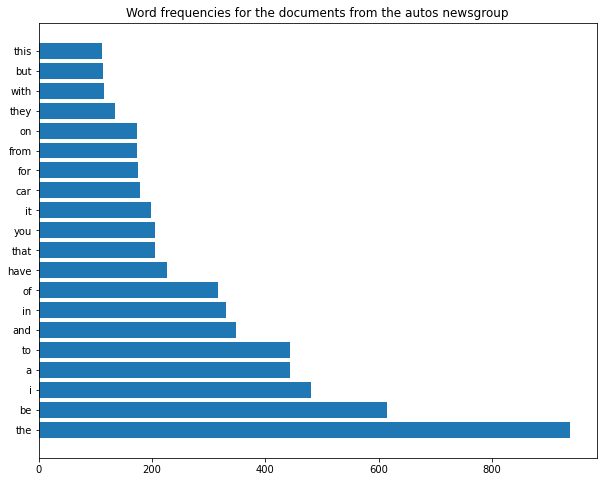

In [28]:
autos_path = os.path.join('data', 'mini_newsgroups', 'rec.autos')
autos = spark.sparkContext.wholeTextFiles(autos_path)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

autos = spark.createDataFrame(autos, schema=schema).persist()

model = pipeline.fit(autos)
processed = model.transform(autos)

vocabulary = model.stages[-1].vocabulary
word_counts = Counter()

for row in processed.toLocalIterator():
    for ix, count in zip(row['bows'].indices, row['bows'].values):
        word_counts[vocabulary[ix]] += count

y = list(range(20))
top_words, counts = zip(*word_counts.most_common(20))

plt.figure(figsize=(10, 8))
plt.barh(y, counts)
plt.yticks(y, top_words)
plt.title('Word frequencies for the documents from the autos newsgroup')
plt.show()

# STEP 02. Spark NLP intermediate

## Ch.01 Building an Inverted Index

In [33]:
import os

from pyspark.sql.types import *
from pyspark.sql.functions import collect_set
from pyspark.sql import Row
from pyspark.ml import Pipeline

import sparknlp
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import *

spark = sparknlp.start()

In [34]:
path = os.path.join('data', 'mini_newsgroups', '*')
texts = spark.sparkContext.wholeTextFiles(path)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

texts = spark.createDataFrame(texts, schema=schema).persist()

In [35]:
rows_w_indexed = texts.rdd.zipWithIndex()
(path, text), i = rows_w_indexed.first()

print(i)
print(path)
print(text[:200])

0
file:/content/data/mini_newsgroups/rec.motorcycles/103203
Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!ogicse!uwm.edu!cs.utexas.edu!uunet!news.crd.ge.com!azores!sprattli
From: sprattli@azores.crd.ge.com (Rod Sprattling)
Newsgroups: rec.motorcycles
Su


In [36]:
indexed = rows_w_indexed.map(
    lambda row_index: Row(
        index=row_index[1], 
        **row_index[0].asDict())
)
(i, path, text) = indexed.first()

In [37]:
indexed_schema = schema.add(StructField('index', IntegerType()))

indexed = spark.createDataFrame(indexed, schema=indexed_schema)\
    .persist()

indexed.limit(10).toPandas()

,path,text,index
0,file:/content/data/mini_newsgroups/rec.motorcy...,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,0
1,file:/content/data/mini_newsgroups/rec.motorcy...,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,1
2,file:/content/data/mini_newsgroups/rec.motorcy...,Path: cantaloupe.srv.cs.cmu.edu!rochester!udel...,2
3,file:/content/data/mini_newsgroups/rec.motorcy...,Newsgroups: rec.motorcycles\nPath: cantaloupe....,3
4,file:/content/data/mini_newsgroups/rec.motorcy...,Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....,4
5,file:/content/data/mini_newsgroups/rec.motorcy...,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,5
6,file:/content/data/mini_newsgroups/rec.motorcy...,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,6
7,file:/content/data/mini_newsgroups/rec.motorcy...,Newsgroups: rec.motorcycles\nPath: cantaloupe....,7
8,file:/content/data/mini_newsgroups/rec.motorcy...,Newsgroups: rec.motorcycles\nPath: cantaloupe....,8
9,file:/content/data/mini_newsgroups/rec.motorcy...,Newsgroups: rec.motorcycles\nPath: cantaloupe....,9


In [38]:
from sparknlp.pretrained import PretrainedPipeline

assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('document')
tokenizer = Tokenizer()\
    .setInputCols(['document'])\
    .setOutputCol('token')
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['token'])\
    .setOutputCol('lemma')
normalizer = Normalizer()\
    .setInputCols(['lemma'])\
    .setOutputCol('normalized')\
    .setLowercase(True)
finisher = Finisher()\
    .setInputCols(['normalized'])\
    .setOutputCols(['normalized'])\
    .setOutputAsArray(True)

pipeline = Pipeline().setStages([
    assembler, tokenizer, 
    lemmatizer, normalizer, finisher
]).fit(indexed)

indexed_w_tokens = pipeline.transform(indexed)

indexed_w_tokens.limit(10).toPandas()

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


,path,text,index,normalized
0,file:/content/data/mini_newsgroups/rec.motorcy...,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,0,"[path, cantaloupesrvcscmuedudasnewsharvardeduo..."
1,file:/content/data/mini_newsgroups/rec.motorcy...,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,1,"[path, cantaloupesrvcscmuedumagnesiumclubcccmu..."
2,file:/content/data/mini_newsgroups/rec.motorcy...,Path: cantaloupe.srv.cs.cmu.edu!rochester!udel...,2,"[path, cantaloupesrvcscmuedurochesterudelbogus..."
3,file:/content/data/mini_newsgroups/rec.motorcy...,Newsgroups: rec.motorcycles\nPath: cantaloupe....,3,"[newsgroups, recmotorcycles, path, cantaloupes..."
4,file:/content/data/mini_newsgroups/rec.motorcy...,Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....,4,"[path, cantaloupesrvcscmueducrabapplesrvcscmue..."
5,file:/content/data/mini_newsgroups/rec.motorcy...,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,5,"[path, cantaloupesrvcscmuedudasnewsharvardedun..."
6,file:/content/data/mini_newsgroups/rec.motorcy...,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,6,"[path, cantaloupesrvcscmuedudasnewsharvardedun..."
7,file:/content/data/mini_newsgroups/rec.motorcy...,Newsgroups: rec.motorcycles\nPath: cantaloupe....,7,"[newsgroups, recmotorcycles, path, cantaloupes..."
8,file:/content/data/mini_newsgroups/rec.motorcy...,Newsgroups: rec.motorcycles\nPath: cantaloupe....,8,"[newsgroups, recmotorcycles, path, cantaloupes..."
9,file:/content/data/mini_newsgroups/rec.motorcy...,Newsgroups: rec.motorcycles\nPath: cantaloupe....,9,"[newsgroups, recmotorcycles, path, cantaloupes..."


In [39]:
doc_index = indexed_w_tokens.select('index', 'path', 'text').toPandas()
doc_index = doc_index.set_index('index')

In [41]:
"""
SELECT term, collect_set(index) AS documents
FROM (
    SELECT index, explode(normalized) AS term
    FROM indexed_w_tokens
)
GROUP BY term
ORDER BY term
"""
inverted_index = indexed_w_tokens\
    .selectExpr('index', 'explode(normalized) AS term')\
    .distinct()\
    .groupBy('term').agg(collect_set('index').alias('documents'))\
    .persist()

inverted_index.show(10)

+--------------------+--------------------+
|                term|           documents|
+--------------------+--------------------+
|        accumulation|               [484]|
|          adventists|              [1419]|
|           amplifier|     [565, 584, 577]|
|            antennae|          [945, 991]|
|             aprdlss|              [1953]|
|aprgalileoccroche...|[1732, 237, 1359,...|
|          aprsqsqcom|               [969]|
|               argle|              [1213]|
|           arguments|         [1717, 802]|
|                 art|[472, 51, 488, 93...|
+--------------------+--------------------+
only showing top 10 rows



In [42]:
inverted_index.count()

42624

In [43]:
inverted_index = {
    term: set(docs) 
    for term, docs in inverted_index.collect()
}

lang_docs = inverted_index['language']
print('docs', ('{}, ' * 10).format(*list(lang_docs)[:10]), '...')
print('number of docs', len(lang_docs))

docs 1154, 1797, 137, 525, 270, 400, 657, 1172, 407, 920,  ...
number of docs 44


In [44]:
info_docs = inverted_index['information']
print('docs', ('{}, ' * 10).format(*list(info_docs)[:10]), '...')
print('number of docs', len(info_docs))

docs 515, 1544, 521, 1035, 1549, 525, 1554, 1044, 20, 537,  ...
number of docs 215


In [45]:
filter_set = list(lang_docs | info_docs)
print('number of docs in filter set', len(filter_set))

number of docs in filter set 246


In [46]:
intersection = list(lang_docs & info_docs)
print('number of docs in intersection set', len(intersection))

number of docs in intersection set 13


In [47]:
k = 1
for i in filter_set:
    path, text = doc_index.loc[i]
    lines = text.split('\n')
    print(path.split('/')[-1], 'length:', len(text))
    for line_number, line in enumerate(lines):
        if 'information' in line or 'language' in line:
            print(line_number, line)
    print()
    k += 1
    if k > 5:
        break

75858 length: 1247
15 	information.  There are three lift tickets and they are good

76441 length: 1101

104863 length: 2795
14 of information that I received, but as my own bad mouthing) I thought that

103553 length: 3766
55  	For pre-registration forms and additional information, write Doug

74755 length: 922
19 the information here.



## Ch.02 Vector Space Model
In the previous chapter, we introduced the concept of vectorizing documents. We talked about creating binary vectors, where 1 means that the word is present in the document. We can also use the counts.

When we convert a corpus to a collection of vectors, we are implicitly modeling our language as a vector space. In this vector space, each dimension represents one term. This has many benefits and drawbacks. It is a simple way to represent our text in a manner that allows machine learning algorithms to work with it. It also allows us to represent the vectors sparsely. On the other hand, we lose the information contained in the word order. This process also creates high dimensional data sets, which can be problematic to some algorithms.

Let's calculate the vectors for our data set. In the previous chapter, we used the CountVectorizer for this. We will build the vectors in Python, but the way we will build them will help us understand how libraries implement vectorization.

In [48]:
class SparseVector(object):
    
    def __init__(self, indices, values, length):
        # if the indices are not in ascending order, we need 
        # to sort them
        is_ascending = True
        for i in range(len(indices) - 1):
            is_ascending = is_ascending and indices[i] < indices[i+1]
        if not is_ascending:
            pairs = zip(indices, values)
            sorted_pairs = sorted(pairs, key=lambda x: x[0])
            indices, values = zip(*sorted_pairs)
        self.indices = indices
        self.values = values
        self.length = length
        
    def __getitem__(self, index):
        try:
            return self.values[self.indices.index(index)]
        except ValueError:
            return 0.0
        
    def dot(self, other):
        assert isinstance(other, SparseVector)
        assert self.length == other.length
        res = 0
        i = j = 0
        while i < len(self.indices) and j < len(other.indices):
            if self.indices[i] == other.indices[j]:
                res += self.values[i] * other.values[j]
                i += 1
                j += 1
            elif self.indices[i] < other.indices[j]:
                i += 1
            elif self.indices[i] > other.indices[j]:
                j += 1
        return res
    
    def hadamard(self, other):
        assert isinstance(other, SparseVector)
        assert self.length == other.length
        res_indices = []
        res_values = []
        i = j = 0
        while i < len(self.indices) and j < len(other.indices):
            if self.indices[i] == other.indices[j]:
                res_indices.append(self.indices[i])
                res_values.append(self.values[i] * other.values[j])
                i += 1
                j += 1
            elif self.indices[i] < other.indices[j]:
                i += 1
            elif self.indices[i] > other.indices[j]:
                j += 1
        return SparseVector(res_indices, res_values, self.length)
    
    def sum(self):
        return sum(self.values)
    
    def __repr__(self):
        return 'SparseVector({}, {})'.format(
            dict(zip(self.indices, self.values)), self.length)

In [49]:
from collections import Counter

vocabulary = set()
vectors = {}

for row in indexed_w_tokens.toLocalIterator():
    counts = Counter(row['normalized'])
    vocabulary.update(counts.keys())
    vectors[row['index']] = counts
    
vocabulary = list(sorted(vocabulary))
inv_vocabulary = {term: ix for ix, term in enumerate(vocabulary)}
vocab_len = len(vocabulary)

In [50]:
for index in vectors:
    terms, values = zip(*vectors[index].items())
    indices = [inv_vocabulary[term] for term in terms]
    vectors[index] = SparseVector(indices, values, vocab_len)


vectors[42]

SparseVector({10: 1, 56: 2, 156: 1, 1480: 2, 1632: 1, 1793: 1, 2079: 1, 2581: 1, 3093: 1, 3969: 2, 5017: 1, 6162: 1, 7259: 1, 7260: 1, 7664: 3, 7666: 3, 7835: 1, 8698: 1, 11031: 1, 12226: 1, 12280: 1, 12383: 1, 15475: 2, 16266: 1, 16463: 1, 16876: 3, 17328: 1, 18102: 2, 18329: 2, 18730: 2, 19620: 1, 19621: 1, 19654: 1, 20626: 1, 20642: 1, 20809: 1, 21404: 1, 21907: 1, 22124: 1, 22225: 1, 22975: 3, 23470: 2, 23813: 1, 23965: 1, 24196: 1, 25058: 3, 26222: 1, 26438: 1, 27220: 2, 27351: 1, 27500: 1, 27897: 1, 28012: 1, 28052: 1, 28120: 1, 28583: 1, 31652: 1, 31850: 1, 32001: 1, 34408: 1, 35471: 1, 35598: 1, 35923: 1, 36027: 1, 36620: 1, 36672: 1, 37867: 2, 37945: 1, 38317: 1, 39534: 1, 39799: 1, 40104: 1, 40737: 2, 41190: 1, 41195: 1, 41731: 1}, 42624)

In [54]:
vocabulary[22975]

'mark'

## Ch.03 Stop-Word Removal

In [62]:
from pyspark.ml.feature import StopWordsRemover

sw_remover = StopWordsRemover() \
    .setInputCol("normalized") \
    .setOutputCol("filtered") \
    .setStopWords(StopWordsRemover.loadDefaultStopWords("english"))

filtered = sw_remover.transform(indexed_w_tokens)
filtered.show()

+--------------------+--------------------+-----+--------------------+--------------------+
|                path|                text|index|          normalized|            filtered|
+--------------------+--------------------+-----+--------------------+--------------------+
|file:/content/dat...|Path: cantaloupe....|    0|[path, cantaloupe...|[path, cantaloupe...|
|file:/content/dat...|Path: cantaloupe....|    1|[path, cantaloupe...|[path, cantaloupe...|
|file:/content/dat...|Path: cantaloupe....|    2|[path, cantaloupe...|[path, cantaloupe...|
|file:/content/dat...|Newsgroups: rec.m...|    3|[newsgroups, recm...|[newsgroups, recm...|
|file:/content/dat...|Path: cantaloupe....|    4|[path, cantaloupe...|[path, cantaloupe...|
|file:/content/dat...|Path: cantaloupe....|    5|[path, cantaloupe...|[path, cantaloupe...|
|file:/content/dat...|Path: cantaloupe....|    6|[path, cantaloupe...|[path, cantaloupe...|
|file:/content/dat...|Newsgroups: rec.m...|    7|[newsgroups, recm...|[newsgroup

In [63]:
from collections import Counter

vocabulary_filtered = set()
vectors_filtered = {}

for row in filtered.toLocalIterator():
    counts = Counter(row['filtered'])
    vocabulary_filtered.update(counts.keys())
    vectors_filtered[row['index']] = counts
    
vocabulary_filtered = list(sorted(vocabulary_filtered))
inv_vocabulary_filtered = {
    term: ix 
    for ix, term in enumerate(vocabulary_filtered)
}
vocab_len_filtered = len(vocabulary)

In [64]:
for index in vectors:
    terms, values = zip(*vectors_filtered[index].items())
    indices = [inv_vocabulary_filtered[term] for term in terms]
    vectors_filtered[index] = \
        SparseVector(indices, values, vocab_len_filtered)

vectors_filtered

{0: SparseVector({1433: 1, 1635: 1, 1782: 1, 2147: 2, 2171: 2, 2569: 1, 2571: 1, 2671: 1, 2673: 1, 3129: 1, 3163: 2, 6340: 1, 7209: 2, 7589: 1, 7626: 1, 8597: 1, 9771: 1, 10061: 1, 11004: 1, 11219: 1, 12074: 1, 13804: 1, 13887: 1, 14866: 1, 15121: 1, 15142: 1, 15843: 1, 16227: 1, 16407: 2, 16541: 1, 17284: 2, 20047: 1, 20476: 1, 21343: 1, 21846: 1, 23751: 1, 24067: 1, 25871: 3, 26234: 1, 26262: 1, 26372: 1, 26760: 1, 27242: 1, 27603: 1, 27821: 1, 28499: 1, 30129: 1, 31541: 1, 31568: 2, 31766: 1, 31917: 1, 32205: 1, 32246: 1, 32958: 3, 32964: 1, 33318: 1, 33816: 1, 34365: 1, 34571: 1, 34795: 1, 35273: 1, 35558: 1, 35931: 3, 35932: 3, 36582: 1, 37099: 1, 38092: 1, 39700: 1, 39711: 1, 39726: 1, 40434: 1, 40584: 1, 40686: 1, 40839: 1, 41605: 2, 41698: 1, 42396: 4}, 42624),
 1: SparseVector({334: 1, 705: 1, 1405: 1, 1406: 1, 1782: 1, 1829: 1, 2429: 1, 2569: 1, 2655: 1, 2699: 2, 2700: 3, 3135: 2, 4054: 1, 4055: 1, 4313: 1, 4555: 1, 4596: 1, 4994: 1, 6673: 1, 7944: 1, 8349: 1, 8660: 1, 10665:

In [65]:
vectors[42]

SparseVector({10: 1, 56: 2, 156: 1, 1480: 2, 1632: 1, 1793: 1, 2079: 1, 2581: 1, 3093: 1, 3969: 2, 5017: 1, 6162: 1, 7259: 1, 7260: 1, 7664: 3, 7666: 3, 7835: 1, 8698: 1, 11031: 1, 12226: 1, 12280: 1, 12383: 1, 15475: 2, 16266: 1, 16463: 1, 16876: 3, 17328: 1, 18102: 2, 18329: 2, 18730: 2, 19620: 1, 19621: 1, 19654: 1, 20626: 1, 20642: 1, 20809: 1, 21404: 1, 21907: 1, 22124: 1, 22225: 1, 22975: 3, 23470: 2, 23813: 1, 23965: 1, 24196: 1, 25058: 3, 26222: 1, 26438: 1, 27220: 2, 27351: 1, 27500: 1, 27897: 1, 28012: 1, 28052: 1, 28120: 1, 28583: 1, 31652: 1, 31850: 1, 32001: 1, 34408: 1, 35471: 1, 35598: 1, 35923: 1, 36027: 1, 36620: 1, 36672: 1, 37867: 2, 37945: 1, 38317: 1, 39534: 1, 39799: 1, 40104: 1, 40737: 2, 41190: 1, 41195: 1, 41731: 1}, 42624)

In [66]:
vocabulary[7664]

'cervi'

In [67]:
vocabulary[7666]

'cervioasysdtnavymil'

## Ch.04 Inverse Document Frequency

In [68]:
idf = Counter()

for vector in vectors.values():
    idf.update(vector.indices)

idf

Counter({56: 1730,
         156: 790,
         1351: 827,
         1396: 1674,
         1443: 1,
         1632: 746,
         1646: 216,
         1793: 1861,
         2158: 17,
         2182: 1,
         2581: 908,
         2583: 88,
         2684: 2,
         2686: 2,
         3143: 1,
         3177: 231,
         3598: 1837,
         4996: 1057,
         5045: 779,
         6366: 1,
         7235: 107,
         7615: 113,
         7652: 70,
         8623: 1,
         9797: 48,
         10088: 1,
         11031: 2000,
         11246: 18,
         12102: 6,
         12352: 1053,
         13839: 6,
         13922: 29,
         14902: 75,
         15157: 34,
         15166: 1474,
         15179: 18,
         15475: 2000,
         15882: 3,
         16266: 1717,
         16446: 1,
         16580: 183,
         17238: 1459,
         17328: 236,
         18329: 1708,
         18730: 1695,
         20107: 70,
         20537: 2,
         21404: 259,
         21907: 1993,
         23813: 2000,

In [69]:
for ix, count in idf.most_common(20):
    print('{:5d} {:20s} {:d}'.format(ix, vocabulary[ix], count))

11031 date                 2000
15475 from                 2000
23813 messageid            2000
26438 newsgroups           2000
28583 path                 2000
36672 subject              2000
21907 lines                1993
27897 organization         1925
37876 the                  1874
 1793 apr                  1861
 3598 be                   1837
38317 to                   1767
27500 of                   1756
   56 a                    1730
16266 gmt                  1717
18329 i                    1708
18730 in                   1695
 1396 and                  1674
15166 for                  1474
17238 have                 1459


In [70]:
indices, values = zip(*idf.items())
idf = SparseVector(indices, values, vocab_len)

idf

SparseVector({0: 172, 1: 33, 2: 8, 3: 4, 4: 1, 5: 1, 6: 2, 7: 1, 8: 2, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 2, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 3, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 3, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1730, 57: 12, 58: 4, 59: 1, 60: 2, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 2, 77: 1, 78: 1, 79: 1, 80: 3, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 2, 90: 5, 91: 1, 92: 2, 93: 1, 94: 3, 95: 12, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 14, 110: 1, 111: 10, 112: 1, 113: 1, 114: 1, 115: 1, 116: 3, 117: 1, 118: 3, 119: 2, 120: 1, 121: 1, 122: 3, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 2, 130: 2, 131: 1, 132: 1, 133: 1, 134: 1, 135: 1

In [71]:
from math import log

for index, vector in vectors.items():
    vector.values = list(map(lambda v: log(1+v), vector.values))
    
idf.values = list(map(lambda v: log(vocab_len / (1+v)), idf.values))

In [72]:
tfidf = {index: tf.hadamard(idf) for index, tf in vectors.items()}

tfidf[42]

SparseVector({10: 6.908615674729574, 56: 3.519644182547685, 156: 2.763491017253213, 1480: 10.50444782594699, 1632: 2.80316175917215, 1793: 2.170081831108205, 2079: 5.186209636474362, 2581: 2.6671108936172803, 3093: 6.908615674729574, 3969: 7.458447784271755, 5017: 3.8755720323503624, 6162: 6.908615674729574, 7259: 6.627568678228966, 7260: 6.908615674729574, 7664: 13.817231349459147, 7666: 13.817231349459147, 7835: 6.273491337357794, 8698: 4.247310129361159, 11031: 2.120178092129274, 12226: 4.9447818333721925, 12280: 4.650275245407864, 12383: 4.551085299102582, 15475: 3.3604027708754245, 16266: 2.2258734939416858, 16463: 5.5598135412889, 16876: 12.856325321622744, 17328: 3.5988982186877423, 18102: 10.188396765921954, 18329: 3.533696391776262, 18730: 3.542085248837542, 19620: 2.3618368673030767, 19621: 6.273491337357794, 19654: 3.1892045289648863, 20626: 4.886171118265028, 20642: 6.428162660811372, 20809: 5.793038323439593, 21404: 3.5346978941178837, 21907: 2.122607146061414, 22124: 3.61

In [76]:
tfidf[42][1480]

10.50444782594699

In [77]:
vocabulary[1480], tfidf[42][1480]

('annapolis', 10.50444782594699)

In [75]:
print(doc_index.loc[42]['text'])

Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!zaphod.mps.ohio-state.edu!darwin.sura.net!dtix.dt.navy.mil!oasys!cervi
From: cervi@oasys.dt.navy.mil (Mark Cervi)
Newsgroups: rec.motorcycles
Subject: Re: ++BIKE SOLD OVER NET 600 MILES AWAY!++
Message-ID: <34370@oasys.dt.navy.mil>
Date: 15 Apr 93 18:23:07 GMT
References: <1993Apr12.204046.4203@magnus.acs.ohio-state.edu> <6130331@hplsla.hp.com>
Organization: NSWC, Carderock Division, Annapolis, MD, USA
Lines: 15

In article <6130331@hplsla.hp.com> kens@hplsla.hp.com (Ken Snyder) writes:
>
>> Any other bikes sold long distances out there...I'd love to hear about
>it!

I bought my Moto Guzzi from a Univ of Va grad student in Charlottesville
last spring.

	     Mark Cervi, cervi@oasys.dt.navy.mil, (w) 410-267-2147
		 DoD #0603  MGNOC #12998  '87 Moto Guzzi SP-II
      "What kinda bikes that?" A Moto Guzzi. "What's that?" Its Italian.
-- 

	Mark Cervi, CARDEROCKDIV, NSWC Code 852, Annapolis, MD  21402


## Ch.05 In Spark

In [79]:
def process_query(query, pipeline):
    data = spark.createDataFrame([(query,)], ['text'])
    return pipeline.transform(data).first()['normalized']

def get_filter_set(processed_query):
    filter_set = set()
    # find all the documents that contain any of the terms
    return filter_set

def get_score(index, terms):
    return # return a single score

def display(index, score, terms):
    hits = [term for term in terms if term in vocabulary and tfidf[index][inv_vocabulary[term]] > 0.]
    print('terms', terms, 'hits', hits)
    print('score', score)
    print('path', path)
    print('length', len(doc_index.loc[index]['text']))

In [80]:
def search(query, pipeline, k=5):
    processed_query = process_query(query, pipeline)
    filter_set = get_filter_set(processed_query)
    scored = {index: get_score(index, processed_query) for index in filter_set}
    display_list = list(sorted(filter_set, key=scored.get, reverse=True))[:k]
    for index in display_list:
        display(index, scored[index], processed_query)

In [83]:
search('search engine', pipeline)

# STEP 03. SPARK MLlib

## Ch.01 Classification & Regression

In [84]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyspark.sql.types import *
from pyspark.sql.functions import expr
from pyspark.sql import Row
from pyspark.ml import Pipeline

import sparknlp
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import *

%matplotlib inline

spark = sparknlp.start()

In [85]:
HEADER_PTN = re.compile(r'^[a-zA-Z-]+:.*')

def remove_header(path_text_pair):
    path, text = path_text_pair
    lines = text.split('\n')
    line_iterator = iter(lines)
    while HEADER_PTN.match(next(line_iterator)) is not None:
        pass
    return path, '\n'.join(line_iterator)

In [86]:
path = os.path.join('data', 'mini_newsgroups', '*')
texts = spark.sparkContext.wholeTextFiles(path).map(remove_header)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

texts = spark.createDataFrame(texts, schema=schema) \
    .withColumn('newsgroup', expr('split(path, "/")[4]')) \
    .persist()

In [87]:
texts.groupBy('newsgroup').count().collect()

[Row(newsgroup='comp.windows.x', count=100),
 Row(newsgroup='misc.forsale', count=100),
 Row(newsgroup='rec.sport.hockey', count=100),
 Row(newsgroup='rec.sport.baseball', count=100),
 Row(newsgroup='talk.politics.guns', count=100),
 Row(newsgroup='talk.politics.misc', count=100),
 Row(newsgroup='comp.os.ms-windows.misc', count=100),
 Row(newsgroup='comp.sys.ibm.pc.hardware', count=100),
 Row(newsgroup='comp.graphics', count=100),
 Row(newsgroup='soc.religion.christian', count=100),
 Row(newsgroup='comp.sys.mac.hardware', count=100),
 Row(newsgroup='talk.religion.misc', count=100),
 Row(newsgroup='talk.politics.mideast', count=100),
 Row(newsgroup='rec.motorcycles', count=100),
 Row(newsgroup='rec.autos', count=100),
 Row(newsgroup='alt.atheism', count=100),
 Row(newsgroup='sci.electronics', count=100),
 Row(newsgroup='sci.space', count=100),
 Row(newsgroup='sci.med', count=100),
 Row(newsgroup='sci.crypt', count=100)]

In [88]:
print(texts.first()['path'])
print(texts.first()['newsgroup'])
print(texts.first()['text'])

file:/content/data/mini_newsgroups/rec.motorcycles/103203
rec.motorcycles
References: <1993Apr3.094509.11448@organpipe.uug.arizona.edu> <1993Apr4.135829.28141@pro-haven.cts.com>
Sender: usenet@crdnns.crd.ge.com (USENET News System)
Reply-To: sprattli@azores.crd.ge.com (Rod Sprattling)
Organization: GE Corp R&D Center, Schenectady NY
Lines: 31
Nntp-Posting-Host: azores.crd.ge.com

In article <1993Apr4.135829.28141@pro-haven.cts.com>,
shadow@pro-haven.cts.com writes:
|>In <1993Apr3.094509.11448@organpipe.uug.arizona.edu>
|>asphaug@lpl.arizona.edu (Erik Asphaug x2773) writes:
|>
|>% By the way, the short-lived Zephyr is essentially a GpZ 550,
|>
|>Why was the "Zephyr" discontinued?  I heard something about a problem with
|>the name, but I never did hear anything certain... 

Ford had an anemic mid-sized car by that name back in the last decade.
I rented one once.  That car would ruin the name "Zephyr" for any other
use.

Rod
---               
Roderick Sprattling		| No job too great, no t

In [89]:
assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('document')
sentence = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentences")
tokenizer = Tokenizer()\
    .setInputCols(['sentences'])\
    .setOutputCol('token')
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['token'])\
    .setOutputCol('lemma')
normalizer = Normalizer()\
    .setCleanupPatterns([
        '[^a-zA-Z.-]+', 
        '^[^a-zA-Z]+', 
        '[^a-zA-Z]+$',
    ])\
    .setInputCols(['lemma'])\
    .setOutputCol('normalized')\
    .setLowercase(True)
finisher = Finisher()\
    .setInputCols(['normalized'])\
    .setOutputCols(['normalized'])\
    .setOutputAsArray(True)
pipeline = Pipeline().setStages([
    assembler, sentence, tokenizer, 
    lemmatizer, normalizer, finisher
]).fit(texts)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [90]:
processed = pipeline.transform(texts).persist()

In [91]:
print(processed.count()) # number of documents

2000


## Ch.02 Bag-of-Words Features

In [92]:
from pyspark.ml.feature import CountVectorizer, IDF

count_vectorizer = CountVectorizer(
    inputCol='normalized', outputCol='tf', minDF=10)
idf = IDF(inputCol='tf', outputCol='tfidf', minDocFreq=10)

bow_pipeline = Pipeline(stages=[count_vectorizer, idf])
bow_pipeline = bow_pipeline.fit(processed)

bows = bow_pipeline.transform(processed)

In [93]:
bows.limit(5).toPandas()[['tf', 'tfidf']]

,tf,tfidf
0,"(6.0, 2.0, 2.0, 0.0, 2.0, 1.0, 3.0, 3.0, 2.0, ...","(0.4384234072589195, 0.1830385468576392, 0.263..."
1,"(15.0, 7.0, 5.0, 5.0, 3.0, 3.0, 4.0, 3.0, 3.0,...","(1.0960585181472986, 0.6406349140017372, 0.658..."
2,"(5.0, 5.0, 3.0, 0.0, 1.0, 0.0, 3.0, 2.0, 1.0, ...","(0.3653528393824329, 0.457596367144098, 0.3952..."
3,"(2.0, 3.0, 2.0, 1.0, 1.0, 0.0, 4.0, 1.0, 0.0, ...","(0.14614113575297316, 0.2745578202864588, 0.26..."
4,"(9.0, 3.0, 2.0, 1.0, 2.0, 0.0, 2.0, 5.0, 0.0, ...","(0.6576351108883792, 0.2745578202864588, 0.263..."


## Ch.03 Regular Expression Features

In [94]:
%%writefile scifi_rules.tsv
\w+(lith|ant|an)ium,mineral
(alien|cosmic|quantum|dimension(al)?),space_word

Writing scifi_rules.tsv


In [95]:
regex_matcher = RegexMatcher() \
    .setOutputCol("regex") \
    .setExternalRules('./scifi_rules.tsv', ',')

In [96]:
regex_finisher = Finisher()\
    .setInputCols(['regex'])\
    .setOutputCols(['regex'])\
    .setOutputAsArray(True)

regex_rule_pipeline = Pipeline().setStages([
    assembler, regex_matcher, regex_finisher
]).fit(texts)

regex_matches = regex_rule_pipeline.transform(texts)

In [97]:
regex_matches.orderBy(expr('size(regex)').desc())\
    .limit(5).toPandas()[['newsgroup', 'regex']]

,newsgroup,regex
0,talk.politics.guns,"[alien, alien, alien, alien, alien, alien, alien]"
1,comp.graphics,"[dimensional, dimension, dimensional, dimension]"
2,sci.med,"[dimensional, alien, dimensional]"
3,sci.space,"[cosmic, cosmic, cosmic]"
4,sci.space,"[quantum, quantum, cosmic]"


## Ch.04 Feature Selection

In [98]:
from pyspark.ml.feature import StopWordsRemover

sw_remover = StopWordsRemover() \
    .setInputCol("normalized") \
    .setOutputCol("filtered") \
    .setStopWords(StopWordsRemover.loadDefaultStopWords("english"))

In [99]:
count_vectorizer = CountVectorizer(inputCol='filtered', 
    outputCol='tf', minDF=10)
idf = IDF(inputCol='tf', outputCol='tfidf', minDocFreq=10)

pipeline = Pipeline() \
    .setStages([
        assembler, 
        sentence, 
        tokenizer, 
        lemmatizer, 
        normalizer, 
        finisher, 
        sw_remover,
        count_vectorizer,
        idf
    ]) \
    .fit(texts)

In [100]:
features = pipeline.transform(texts).persist()

In [101]:
features.printSchema()

root
 |-- path: string (nullable = true)
 |-- text: string (nullable = true)
 |-- newsgroup: string (nullable = true)
 |-- normalized: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)
 |-- tfidf: vector (nullable = true)



In [102]:
pipeline.stages

[DocumentAssembler_63a3cfbe6600,
 SentenceDetector_6462a1f6a39f,
 REGEX_TOKENIZER_2f8a001b0dba,
 LEMMATIZER_c62ad8f355f9,
 NORMALIZER_7204c40d2cc1,
 Finisher_4d25a9dc9447,
 StopWordsRemover_1f8e11262448,
 CountVectorizer_b0c9507ec73c,
 IDF_dcb0d0b28434]

In [105]:
cv_model = pipeline.stages[-2]
cv_model

CountVectorizer_b0c9507ec73c

In [104]:
len(cv_model.vocabulary)

3033

In [106]:
cv_model.vocabulary[:10]

['write', 'one', 'use', 'get', 'article', 'say', 'know', 'x', 'make', 'dont']

In [107]:
tf = features.select('tf').toPandas()
tf = tf['tf'].apply(lambda sv: sv.toArray())
mean_tf = pd.Series(tf.mean(), index=cv_model.vocabulary)

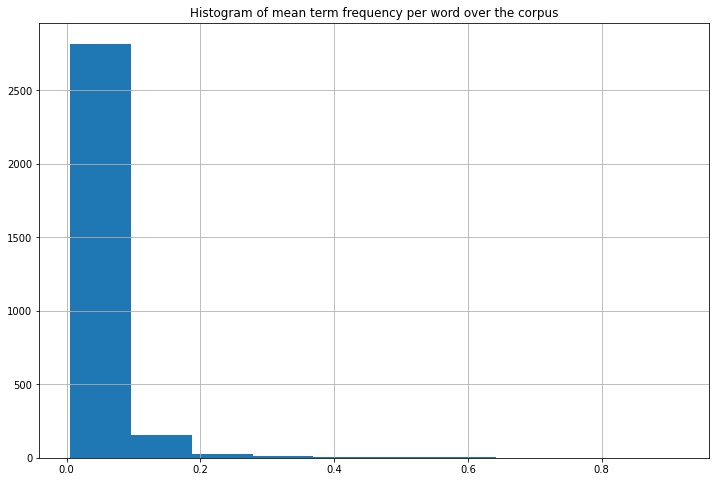

In [108]:
plt.figure(figsize=(12, 8))
mean_tf.hist(bins=10)
plt.title('Histogram of mean term frequency per word over the corpus')
plt.show()

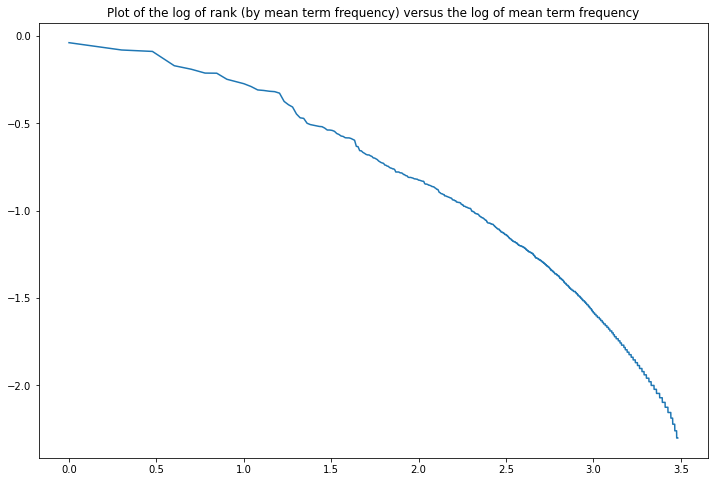

In [109]:
plt.figure(figsize=(12, 8))
ranks = np.arange(len(mean_tf)) + 1
plt.plot(np.log10(ranks), np.log10(mean_tf.values))
plt.title('Plot of the log of rank (by mean term frequency) versus the log of mean term frequency')
plt.show()

This is normally what you see with a vocabulary distribution. Notice, that even though we removed the most common words, and dropped very rare words, by setting minDF to 10, we still have the expected distribution.

Now that we have our features and have assured ourselves that we have not disturbed the expected distribution of words, how can we reduce the number of features? We could try and add more words to our stop-word list, or we could increase our minDF to remove more rare words. But let's think about a more principled way to approach this. Many of the more well-known techniques for reducing the number of features, for example looking at the univariate predictive power of each feature, will not work well with text. The strength of bag-of-words features is their interactions. So we may throw away features that are not powerful on their own but could be very powerful in combination. The high dimensionality means that we can't explore all the possible interactions. So what can we do?

We can use a dictionary of words or phrases that domain experts have selected as important to the problem. We can also build a tree-based model, for example, random forest, and use the feature importances to select a subset of features. This can work because the random forest model is nonlinear and can discover interactions—so, a word that is important only in combination.

We will look at other techniques for reducing dimensionality in the "Topic Modeling" and "Word Embeddings". Now, let's discuss the modeling of text using TF.IDF features.

## Ch.05 Modeling

In [110]:
train, test = texts.randomSplit([0.8, 0.2], seed=123)

stopwords = set(StopWordsRemover.loadDefaultStopWords("english"))

In [111]:
sw_remover = StopWordsRemover() \
    .setInputCol("normalized") \
    .setOutputCol("filtered") \
    .setStopWords(list(stopwords))

count_vectorizer = CountVectorizer(inputCol='filtered', 
    outputCol='tf', minDF=10)
idf = IDF(inputCol='tf', outputCol='tfidf', minDocFreq=10)

text_processing_pipeline = Pipeline(stages=[
        assembler, 
        sentence, 
        tokenizer, 
        lemmatizer, 
        normalizer, 
        finisher, 
        sw_remover,
        count_vectorizer,
        idf
    ])

In [112]:
from pyspark.ml.feature import IndexToString, StringIndexer
from pyspark.ml.classification import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *

In [113]:
label_indexer = StringIndexer(inputCol='newsgroup', outputCol='label').fit(texts)
# Use NaiveBayes Model, it is a model what usually used for baseline model
naive_bayes = NaiveBayes(featuresCol='tfidf')
prediction_deindexer = IndexToString(inputCol='prediction', outputCol='pred_newsgroup', 
                                     labels=label_indexer.labels)

pipeline = Pipeline(stages=[
    text_processing_pipeline, label_indexer, naive_bayes, prediction_deindexer
])

In [114]:
model = pipeline.fit(train)

train_predicted = model.transform(train)
test_predicted = model.transform(test)

In [115]:
evaluator = MulticlassClassificationEvaluator(metricName='f1')

print('train_f1_score : ', evaluator.evaluate(train_predicted))
print('test_f1_score : ', evaluator.evaluate(test_predicted))

train_f1_score :  0.9350772876075861
test_f1_score :  0.6068913102587725


## Ch.06 preprocessing for DL(Use Sequence Model with Keras)

In [116]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed spark-nlp==2.5.1

openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)
  Using cached pyspark-2.4.4-py2.py3-none-any.whl
  Using cached py4j-0.10.7-py2.py3-none-any.whl (197 kB)


  Using cached spark_nlp-2.5.1-py2.py3-none-any.whl (121 kB)


In [148]:
import nltk

nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [149]:
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

import sparknlp

spark = sparknlp.start()

from nltk.corpus import brown
sentences = brown.sents()

In [150]:
def detokenize(sentence):
    text = ''
    for token in sentence:
        if text and any(c.isalnum() for c in token):
            text += ' '
        text += token
    return text

In [151]:
word_counts = Counter()
raw = []
labels = []
for fid in brown.fileids():
        sentences = brown.sents(fid)
        word_counts.update(
            [t for s in sentences for t in s if t.isalpha()])
        sentences = [detokenize(s) for s in sentences]
        raw.append(' '.join(sentences))
        labels.append('S'.join([
            ('S' * (len(s) - 1)) + 'E' 
            for s in sentences
        ]))

word_counts = pd.Series(word_counts)

In [152]:
class HMM(object):
    def __init__(self, obs_set, state_set, initial_log, emission_log, 
                 transition_log):
        self.obs_set = obs_set
        self.state_set = state_set
        self.initial_log = initial_log
        self.emission_log = emission_log
        self.transition_log = transition_log

In [153]:
def training_data():
    data_dict = {}
    data_dict['obs_set'] = set()
    data_dict['state_set'] = set()
    data_dict['transition_ct'] = defaultdict(Counter)
    data_dict['emission_ct'] = defaultdict(Counter)
    data_dict['initial_ct'] = Counter()
    return data_dict

In [154]:
def update_state(data_dict, ob_seq, st_seq):
    assert len(ob_seq) == len(st_seq)
    data_dict['initial_ct'][st_seq[0]] += 1
    for i in range(1, len(st_seq)):
        ob = ob_seq[i]
        st = st_seq[i]
        data_dict['obs_set'].add(ob)
        data_dict['state_set'].add(st)
        data_dict['transition_ct'][ob_seq[i-1]][ob] += 1
        data_dict['emission_ct'][st][ob] += 1

In [155]:
def calculate_sums(data_dict):
    data_dict['transition_sums'] = {
        st: np.sum(list(data_dict['transition_ct'][st].values())) 
        for st in data_dict['state_set']
    }
    data_dict['initial_sum'] = np.sum(
        list(data_dict['initial_ct'].values()))
    data_dict['emission_sums'] = {
        st: np.sum(list(data_dict['emission_ct'][st].values())) 
        for st in data_dict['state_set']
    }

In [156]:
def calculate_log_probs(data_dict, eps):
    data_dict['transition_log'] = {
        prev_st: {
            # log P[y_i = k | y_i-1 = k']
            st: (np.log(data_dict['transition_ct'][prev_st][st] + \
                        eps) - \
                 np.log(data_dict['transition_sums'][prev_st] + \
                        eps)) 
            for st in data_dict['state_set']
        } 
        for prev_st in data_dict['state_set']
    }
    
    data_dict['initial_log'] = {
            # log P[y_0 = k]
        st: (np.log(data_dict['initial_ct'][st] + eps) - \
             np.log(data_dict['initial_sum'] + eps)) 
        for st in data_dict['state_set']
    }
    
    data_dict['emission_log'] = {
        st: {
            # log P[x_i = c | y_i = k]
            ob: (np.log(data_dict['emission_ct'][st][ob] + eps) - \
                 np.log(data_dict['emission_sums'][st] + eps)) 
            for ob in data_dict['obs_set']
        } 
        for st in data_dict['state_set']
    }

In [157]:
def train(observations, states, eps=1e-8):
    # initialize
    data_dict = training_data()
    
    # traverse data and count all transitions, initials, and 
    # emissions
    for ob_seq, st_seq in zip(observations, states):
        update_state(data_dict, ob_seq, st_seq)
                
    calculate_sums(data_dict)
    
    calculate_log_probs(data_dict, eps)
    
    return HMM(list(data_dict['obs_set']), list(data_dict['state_set']), 
               data_dict['initial_log'], data_dict['emission_log'], 
               data_dict['transition_log'])

In [158]:
model = train(raw, labels)

In [159]:
def viterbi(y, model):
    # probabilities for the initial states
    path_logs = [{
        st: model.initial_log[st] + model.emission_log[st][y[0]] 
        for st in model.state_set
    }]
    path_preds = [{st: '' for st in model.state_set}]
    
    for i in range(1, len(y)):
        curr_log = {}
        curr_preds = {}
        for st in model.state_set:
            # find the most probable previous state that 
            # would lead to st
            curr_log[st] = -np.inf
            curr_preds[st] = ''
            for prev_st in model.state_set:
                # log probability
                local_log = path_logs[i-1][prev_st] + \
                    model.transition_log[prev_st][st] + \
                    model.emission_log[st][y[i]]
                if curr_log[st] < local_log:
                    curr_log[st] = local_log
                    curr_preds[st] = prev_st
        path_logs.append(curr_log)
        path_preds.append(curr_preds)

    # Now we work backwards. Find the most probable final 
    # state, and work back to the beginning.
    terminal_log = -np.inf
    curr_st = ''
    for st in model.state_set:
        if terminal_log < path_logs[-1][st]:
            terminal_log = path_logs[-1][st]
            curr_st = st
    preds = curr_st
    for i in range(len(y)-1, 0, -1):
        curr_st = path_preds[i][curr_st]
        preds = curr_st + preds
    return preds

In [160]:
def split(text, model):
    state_seq = viterbi(text, model)
    sentences = []
    start = 0
    for end in range(1, len(text)):
        if state_seq[end] == 'E':
            sentences.append(text[start:end+1])
            start = end+1
    sentences.append(text[start:])
    return sentences

In [161]:
example = raw[0]

print('\n###\n'.join(split(example, model)[:10]))

The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced`` no evidence'' that any irregularities took place.
###
 The jury further said in term-
###
end presentments that the City Executive Committee, which had over-
###
all charge of the election,`` deserves the praise and thanks of the City of Atlanta'' for the manner in which the election was conducted.
###
 The September-
###
October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible`` irregularities'' in the hard-
###
fought primary which was won by Mayor-
###
nominate Ivan Allen Jr.
###
.
###
 `` Only a relative handful of such reports was received'', the jury said,`` considering the widespread interest in the election, the number of voters and the size of this city''.


In [162]:
example_df = spark.createDataFrame([(example,)], ['text'])
example_df.show()

+--------------------+
|                text|
+--------------------+
|The Fulton County...|
+--------------------+



In [163]:
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import SentenceDetector

from pyspark.ml import Pipeline

assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('document')
sent_detector = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentences')
finisher = Finisher()\
    .setInputCols(['sentences'])\
    .setOutputCols(['sentences'])\
    .setOutputAsArray(True)

pipeline = Pipeline().setStages([
    assembler, sent_detector, finisher
]).fit(example_df)

sentences = pipeline.transform(example_df)

print('\n###\n'.join(sentences.first()['sentences'][:10]))

The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced`` no evidence'' that any irregularities took place.
###
The jury further said in term-end presentments that the City Executive Committee, which had over-all charge of the election,`` deserves the praise and thanks of the City of Atlanta'' for the manner in which the election was conducted.
###
The September-October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible`` irregularities'' in the hard-fought primary which was won by Mayor-nominate Ivan Allen Jr..
###
`` Only a relative handful of such reports was received'', the jury said,`` considering the widespread interest in the election, the number of voters and the size of this city''.
###
The jury said it did find that many of Georgia's registration and election laws`` are outmoded or inadequate and often ambiguous''.
###
It recommended that Fulton legislators act`` to have thes

In [164]:
from sparknlp.training import POS

with open('tagged_brown.txt', 'w') as out:
    for fid in brown.fileids():
        for sent in brown.tagged_sents(fid):
            for token, tag in sent:
                out.write('{}_{} '.format(token, tag))
            out.write('\n')
        
tag_data = POS().readDataset(spark, 'tagged_brown.txt', '_', 'tags')

In [165]:
from sparknlp.annotator import Tokenizer, PerceptronApproach

assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('document')
sent_detector = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentences')
tokenizer = Tokenizer() \
    .setInputCols(['sentences']) \
    .setOutputCol('tokens')

pos_tagger = PerceptronApproach() \
    .setNIterations(1) \
    .setInputCols(["sentences", "tokens"]) \
    .setOutputCol("pos") \
    .setPosCol("tags")

finisher = Finisher()\
    .setInputCols(['tokens', 'pos'])\
    .setOutputCols(['tokens', 'pos'])\
    .setOutputAsArray(True)

pipeline = Pipeline().setStages([
    assembler, sent_detector, tokenizer, pos_tagger, finisher
])

pipeline = pipeline.fit(tag_data)

tag_data.first()['text']

"The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place ."

In [166]:
tag_data_first = tag_data.first()['tags']
txformed_first = pipeline.transform(tag_data).first()

for i in range(len(tag_data_first)):
    word = tag_data_first[i]['metadata']['word']
    true_pos = tag_data_first[i]['result']
    pred_pos = txformed_first['pos'][i]
    print('{:20s} {:5s} {:5s}'.format(word, true_pos, pred_pos))

The                  AT    AT   
Fulton               NP-TL NP-TL
County               NN-TL NN-TL
Grand                JJ-TL NN-TL
Jury                 NN-TL NN-TL
said                 VBD   VBD  
Friday               NR    NR   
an                   AT    AT   
investigation        NN    NN   
of                   IN    IN   
Atlanta's            NP$   NP$  
recent               JJ    JJ   
primary              NN    JJ   
election             NN    NN   
produced             VBD   VBN  
``                   ``    ``   
no                   AT    AT   
evidence             NN    NN   
''                   ''    ''   
that                 CS    CS   
any                  DTI   DTI  
irregularities       NNS   NNS  
took                 VBD   VBD  
place                NN    NN   
.                    .     .    


# STEP 04. PySpark

## Ch. 01 LDA

In [135]:
import os
import re

import numpy as np
import pandas as pd

from pyspark.sql.types import *
from pyspark.sql.functions import expr
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark.ml.clustering import LDA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import sparknlp
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import *

%matplotlib inline

spark = sparknlp.start()

In [136]:
HEADER_PTN = re.compile(r'^[a-zA-Z-]+:.*')

def remove_header(path_text_pair):
    path, text = path_text_pair
    lines = text.split('\n')
    line_iterator = iter(lines)
    while HEADER_PTN.match(next(line_iterator)) is not None:
        pass
    return path, '\n'.join(line_iterator)

In [137]:
path = os.path.join('data', 'mini_newsgroups', '*')
texts = spark.sparkContext.wholeTextFiles(path).map(remove_header)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

texts = spark.createDataFrame(texts, schema=schema) \
    .withColumn('newsgroup', expr('split(path, "/")[4]')) \
    .persist()

train, test = texts.randomSplit([0.8, 0.2], seed=123)

In [138]:
texts.limit(5).toPandas()

,path,text,newsgroup
0,file:/content/data/mini_newsgroups/rec.motorcy...,References: <1993Apr3.094509.11448@organpipe.u...,rec.motorcycles
1,file:/content/data/mini_newsgroups/rec.motorcy...,dsc3jfs@nmrdc1.nmrdc.nnmc.navy.mil (Jim Small)...,rec.motorcycles
2,file:/content/data/mini_newsgroups/rec.motorcy...,In article <1993Apr26.002631.1@acfcluster.nyu....,rec.motorcycles
3,file:/content/data/mini_newsgroups/rec.motorcy...,In article <1993Apr21.053721.551@bnr.ca> MBEAV...,rec.motorcycles
4,file:/content/data/mini_newsgroups/rec.motorcy...,In article <1993Apr2.144102.7445@rd.hydro.on.c...,rec.motorcycles


In [139]:
assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('document')
sentence = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentences")
tokenizer = Tokenizer()\
    .setInputCols(['sentences'])\
    .setOutputCol('token')
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['token'])\
    .setOutputCol('lemma')
normalizer = Normalizer()\
    .setCleanupPatterns([
        '[^a-zA-Z.-]+', 
        '^[^a-zA-Z]+', 
        '[^a-zA-Z]+$',
    ])\
    .setInputCols(['lemma'])\
    .setOutputCol('normalized')\
    .setLowercase(True)
finisher = Finisher()\
    .setInputCols(['normalized'])\
    .setOutputCols(['normalized'])\
    .setOutputAsArray(True)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [140]:
stopwords = set(StopWordsRemover.loadDefaultStopWords("english"))

sw_remover = StopWordsRemover() \
    .setInputCol("normalized") \
    .setOutputCol("filtered") \
    .setStopWords(list(stopwords))

count_vectorizer = CountVectorizer(
    inputCol='filtered', outputCol='tf', minDF=10)
idf = IDF(inputCol='tf', outputCol='tfidf')

In [141]:
lda = LDA(
    featuresCol='tfidf',
    seed=123,
    maxIter=20,
    k=100,
    topicDistributionCol='topicDistribution',
)

vec_assembler = VectorAssembler(
    inputCols=['tfidf', 'topicDistribution'])

In [142]:
logreg = LogisticRegression(
    featuresCol='topicDistribution',
    maxIter=100,
    regParam=0.0,
    elasticNetParam=0.0,
)

In [143]:
label_indexer = StringIndexer(
    inputCol='newsgroup', outputCol='label')

pipeline = Pipeline().setStages([
    assembler, sentence, tokenizer, 
    lemmatizer, normalizer, finisher,
    sw_remover, count_vectorizer, idf,
    lda, vec_assembler, 
    label_indexer, logreg
])

In [144]:
evaluator = MulticlassClassificationEvaluator(metricName='f1')

In [145]:
model = pipeline.fit(train)

In [146]:
train_predicted = model.transform(train)
test_predicted = model.transform(test)

In [147]:
print('train_f1_score : ', evaluator.evaluate(train_predicted))
print('test_f1_score : ', evaluator.evaluate(test_predicted))

train_f1_score :  0.5656659033640999
test_f1_score :  0.41870733777203145
